Nome: César Augusto Julio da Silva \\
DRE: 116151713

## **Métodos a serem implementados**

Os métodos escolhidos para serem utilizados são:
- **Redes Neurais**
- **SVM**
- **Árvore de Decisão**

Esses métodos foram escolhidos pois eu os considero mais simples de entender e executar, e moldam-se bem em configurações não lineares com a quantidade de dimensões do database.

A database escolhida foi:

- House Prices - Advanced Regression Techniques \\
Esse conjunto de dados contém diversas características de casas vendidas junto com seus preços de venda. \\

Características de escolha:
- Pelo menos 1000 e, pelo menos 20 colunas: ao utilizar redes neurais no dataset Íris, foi muito fácil para a rede conseguir se adaptar devido ao tamanho do banco. Então queria aumentar a dificuldade que os métodos teriam para que pudesse ver um pouco mais de seus pontenciais.
- Banco focado em classificação (e com mais de duas): apesar desse banco ser focado em previsão e, os métodos, em classificação, foi criada uma nova variável baseada nos valores de venda que terá X quantidade de valores possíveis e substituiu-se essa coluna (para que a máquina não basea-se somente nesse parâmetro).

Slides da aula: \\
https://drive.google.com/drive/folders/16Fb9L-WNqZYHTlkv-4R_wpyZc5saNp0F

## **Importações**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

from google.colab import files
import io
import os

import random
import itertools

In [ ]:
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
df = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))

## **Tratamento da base**

### **Análise dos valores de venda**

Primeiramente vamos observar a distribuição dos valores, tentar averiguar valores discrepantes, etc.

In [ ]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


Vamos criar um novo dataframe para reorganizá-lo em ordem crescente dos preços e fazer alguns gráficos para visualização dos dados.

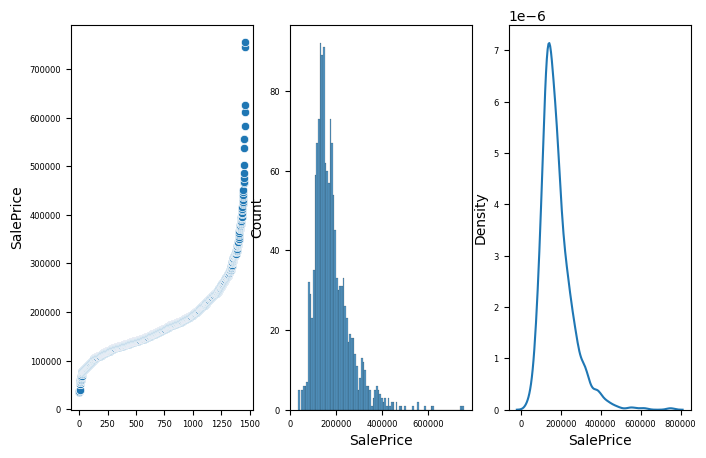

In [ ]:
df2 = df.copy(deep=True)
df2 = df2.sort_values(by='SalePrice')
df2.index = range(1460)

#Grafico para análise
fig, ax = plt.subplots(1,3)
sns.scatterplot(df2['SalePrice'], ax=ax[0])
sns.histplot(df2['SalePrice'], bins=100, ax=ax[1])
sns.kdeplot(df2['SalePrice'], ax=ax[2])

fig.set_figheight(5)
fig.set_figwidth(8)
for a in ax:
  a.tick_params(axis='x', labelsize=6)
  a.tick_params(axis='y', labelsize=6)
fig.show()

Como é possível ver, existe uma grande concentração de valores na faixa de $200000 o que mostra não ser recomendado uma divisão equalitária dos valores e nem dos possíveis intervalos. \\
Devido ao fato de não conseguir estimar de uma forma precisa, estarei dividindo as categorias de diversas formas diferentes e testando os aprendizados.

Também averiguei as correlações entre as variáveis faltantes

<Axes: >

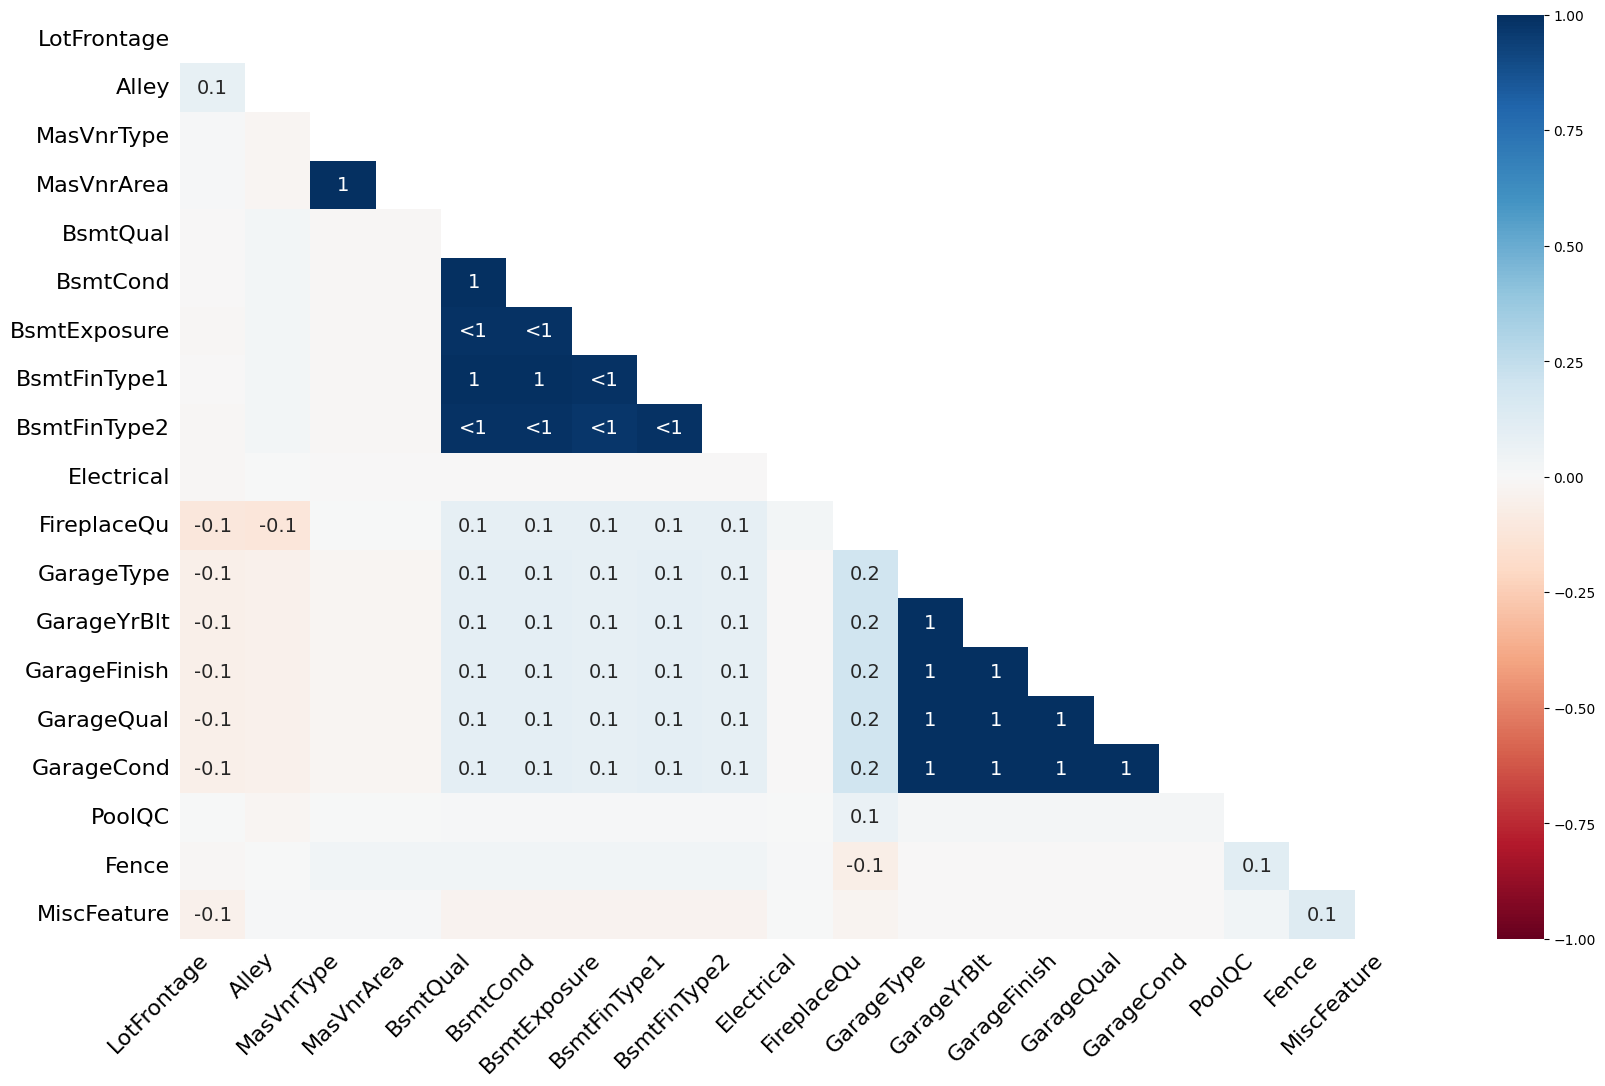

In [ ]:
msno.heatmap(df2)

É possível ver várias variáveis com alto nivel de correlação, isso me mostra que é possível que o método de imputação não funcione tão bem.

### **Tratamento de NaNs**

A base tem uma grande quantidade de valores faltantes, para tratá-los algumas abordagens serão feitas:
- Vamos remover todos os valores faltantes (NaN).
- Vamos remover todas as colunas com mais de 10% de valores faltantes e usar uma contante (moda) para as outras colunas.
- Vamos remover todas as colunas com mais de 10% de valores faltantes e usar regressão para as outras colunas.

#### **Remoção de todos os valores**

In [ ]:
#Cria copia do dataframe
df_rmv_all = df2.copy(deep=True)

#Remove todos as colunas com NaNs
df_rmv_all = df_rmv_all.dropna(axis="columns")
df_rmv_all

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,496,30,C (all),7879,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,115,0,0,0,0,11,2009,WD,Abnorml,34900
1,917,20,C (all),9000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2006,WD,Abnorml,35311
2,969,50,RM,5925,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2009,WD,Abnorml,37900
3,534,20,RL,5000,Pave,Reg,Low,AllPub,Inside,Mod,...,0,0,0,0,0,1,2007,WD,Normal,39300
4,31,70,C (all),8500,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,172,0,0,0,0,7,2008,WD,Normal,40000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,804,60,RL,13891,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,192,0,0,1,2009,New,Partial,582933
1456,899,20,RL,12919,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2010,New,Partial,611657
1457,1170,60,RL,35760,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,7,2006,WD,Normal,625000
1458,1183,60,RL,15623,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,555,0,7,2007,WD,Abnorml,745000


#### **Remoção das colunas com mais de 10% e inclusão da moda no resto**

In [ ]:
df_mode = df2.copy(deep=True)

#Função que acha a moda de valores categoricos
def mode_categorical(l):
  a = {}
  for v in l:
    if(v in a):
      a[v] += 1
    else:
      a[v] = 1
  return max(a, key=a.get)

for col in df2:
  #Checa porcentagem de Nans na coluna
  nans_percentage = df2[col].isna().sum()/len(df2[col])

  #Se maior que 10%, remove a coluna
  if(nans_percentage > 0.1):
    df_mode.drop(col, inplace=True, axis=1)
  #Senão, checa se existe algum NaN na coluna e, se existir, substitue os NaNs pela moda
  elif(nans_percentage):
    m = mode_categorical(df2[col])
    for j, nan in enumerate(df2[col].isna()):
      if(nan):
        df_mode.loc[j, col] = m
df_mode

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,496,30,C (all),7879,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,115,0,0,0,0,11,2009,WD,Abnorml,34900
1,917,20,C (all),9000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2006,WD,Abnorml,35311
2,969,50,RM,5925,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2009,WD,Abnorml,37900
3,534,20,RL,5000,Pave,Reg,Low,AllPub,Inside,Mod,...,0,0,0,0,0,1,2007,WD,Normal,39300
4,31,70,C (all),8500,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,172,0,0,0,0,7,2008,WD,Normal,40000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,804,60,RL,13891,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,192,0,0,1,2009,New,Partial,582933
1456,899,20,RL,12919,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2010,New,Partial,611657
1457,1170,60,RL,35760,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,7,2006,WD,Normal,625000
1458,1183,60,RL,15623,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,555,0,7,2007,WD,Abnorml,745000


### **Criação das Categorias**

Diversos testes serão feitos com valores diferentes de categorias, almejando o maior tamanho de categorias (com menores intervalos) com a maior precisão possível.

In [ ]:
#Lista com todos os dataframes
dfs = [df_rmv_all, df_mode]

NUMBER_START = 10

#### **Divisão de categorias por quantidade de instâncias**

Nesse experimento, iremos focar em ter uma distribuição razoavelmente equalitária de variáveis por categoria, começando de um valor A e diminuindo até perdermos precisão. Começaremos com um valor arbritário de 10 categorias e iremos aumentando a quantidade.

In [ ]:
#Criação das categorias
def createCategoriesQuantity(dfs_quantity, size):
  for df in dfs_quantity:
    #Intervalo de preços
    interval = round(len(df.index)/size)
    new_column = []
    for i in range(size):
      new_column += [f'{df["SalePrice"].iloc[interval*i]}:{df["SalePrice"].iloc[(interval*(i+1))-1]}' for x in range(interval)]
    df['PriceRange'] = new_column
    df.drop("SalePrice", inplace = True, axis=1)
  return dfs_quantity

dfs_quantity = []
for df in dfs:
  dfs_quantity.append(df.copy(deep=True))

dfs_quantity = createCategoriesQuantity(dfs_quantity, NUMBER_START)

dfs_quantity[0]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,PriceRange
0,496,30,C (all),7879,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,115,0,0,0,0,11,2009,WD,Abnorml,34900:106250
1,917,20,C (all),9000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2006,WD,Abnorml,34900:106250
2,969,50,RM,5925,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2009,WD,Abnorml,34900:106250
3,534,20,RL,5000,Pave,Reg,Low,AllPub,Inside,Mod,...,0,0,0,0,0,1,2007,WD,Normal,34900:106250
4,31,70,C (all),8500,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,172,0,0,0,0,7,2008,WD,Normal,34900:106250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,804,60,RL,13891,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,192,0,0,1,2009,New,Partial,278000:755000
1456,899,20,RL,12919,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2010,New,Partial,278000:755000
1457,1170,60,RL,35760,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,7,2006,WD,Normal,278000:755000
1458,1183,60,RL,15623,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,555,0,7,2007,WD,Abnorml,278000:755000


#### **Divisão de categorias por faixa de preço**

Nesse experimento, iremos focar em ter uma distribuição razoavelmente equalitária de valor de venda de cada instância, começando de um intervalo A e diminuindo até perdermos precisão.
Começaremos com um valor arbritário de 10 intervalos e iremos aumentando a quantidade.

In [ ]:
def createCategoriesPriceRange(dfs_range, size):
  for df in dfs_range:
    #Intervalo de preços
    minimum = min(df["SalePrice"])
    interval = (max(df["SalePrice"])-minimum)/size
    new_column = []
    i = 0
    for price in df["SalePrice"]:
      if(price <= minimum+interval*(i+1)):
        new_column += [f'{minimum+interval*i}:{minimum+interval*(i+1)}']
      else:
        i += 1
        new_column += [f'{minimum+interval*i}:{minimum+interval*(i+1)}']

    df["PriceRange"] = new_column
    df = df.drop("SalePrice", inplace=True, axis=1)
  return dfs_range

dfs_range = []
for df in dfs:
  dfs_range.append(df.copy(deep=True))

dfs_range = createCategoriesPriceRange(dfs_range, NUMBER_START)

dfs_range[0]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,PriceRange
0,496,30,C (all),7879,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,115,0,0,0,0,11,2009,WD,Abnorml,34900.0:106910.0
1,917,20,C (all),9000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2006,WD,Abnorml,34900.0:106910.0
2,969,50,RM,5925,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2009,WD,Abnorml,34900.0:106910.0
3,534,20,RL,5000,Pave,Reg,Low,AllPub,Inside,Mod,...,0,0,0,0,0,1,2007,WD,Normal,34900.0:106910.0
4,31,70,C (all),8500,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,172,0,0,0,0,7,2008,WD,Normal,34900.0:106910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,804,60,RL,13891,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,192,0,0,1,2009,New,Partial,538970.0:610980.0
1456,899,20,RL,12919,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2010,New,Partial,610980.0:682990.0
1457,1170,60,RL,35760,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,7,2006,WD,Normal,610980.0:682990.0
1458,1183,60,RL,15623,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,555,0,7,2007,WD,Abnorml,682990.0:755000.0


## **Aplicação do aprendizado de máquina**

In [ ]:
R_STATE = 100

### **Árvore de Decisão**

#### **Teste do <i>dfs_quantity</i>**

In [ ]:
for df in dfs_quantity:
  #Separar x e y
  x = df.iloc[:, df.columns != 'PriceRange']
  y = df['PriceRange']

  categorical_features = x.select_dtypes(include=['object']).columns
  x_encoded = pd.get_dummies(x, columns=categorical_features)

  #Separação de 20% para teste (random_state = 100, para efeitos de reprodutibilidade)
  x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=R_STATE)

  kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=R_STATE)

  accuracy_scores = []

  for train_index, test_index in kf.split(x_train, y_train):
      x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[test_index]
      y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

      #Cria árovre de decisão
      tree = DecisionTreeClassifier()

      #Treina classificador
      tree.fit(x_train_fold, y_train_fold)

      # Make predictions on the validation fold
      y_val_pred = tree.predict(x_val_fold)

      #Calcula acurácia
      accuracy = accuracy_score(y_val_fold, y_val_pred)
      accuracy_scores.append(accuracy)

  #Calcula acurácia media
  average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
  print('Acurácia Media:', average_accuracy)

  #Pega as previsões do classificador
  y_test_pred = tree.predict(x_test)

  #Calcula acurácia do teste
  test_accuracy = accuracy_score(y_test, y_test_pred)
  print('Acurácia do Teste:', test_accuracy)

Acurácia Media: 0.3604820072631231
Acurácia do Teste: 0.3767123287671233
Acurácia Media: 0.3561388063533987
Acurácia do Teste: 0.3732876712328767


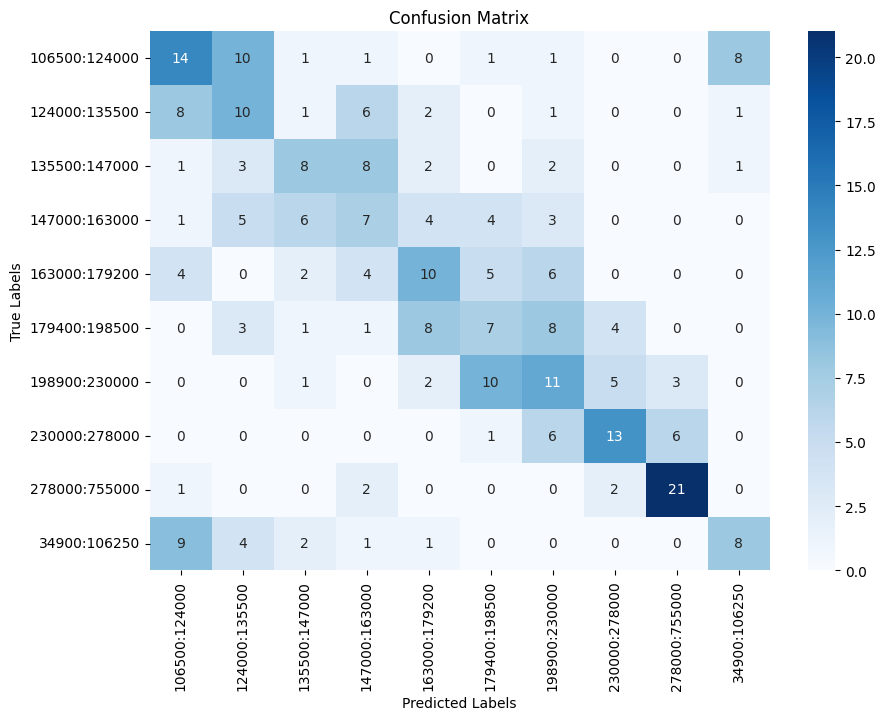

In [ ]:
#Pegando valor previsto
y_test_pred = tree.predict(x_test)

#Construindo matrix de confusão
cm = confusion_matrix(y_test, y_test_pred)

#Converte para dataframe
cm_df = pd.DataFrame(cm, index=tree.classes_, columns=tree.classes_)

#Cria o gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### **Teste do <i>dfs_range</i>**

In [ ]:
for df in dfs_range:
  #Separar x e y
  x = df.iloc[:, df.columns != 'PriceRange']
  y = df['PriceRange']

  categorical_features = x.select_dtypes(include=['object']).columns
  x_encoded = pd.get_dummies(x, columns=categorical_features)

  #Separação de 20% para teste (random_state = 100, para efeitos de reprodutibilidade)
  x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=R_STATE)

  kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=R_STATE)

  accuracy_scores = []

  for train_index, test_index in kf.split(x_train, y_train):
      x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[test_index]
      y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

      #Cria árovre de decisão
      tree = DecisionTreeClassifier()

      #Treina classificador
      tree.fit(x_train_fold, y_train_fold)

      # Make predictions on the validation fold
      y_val_pred = tree.predict(x_val_fold)

      #Calcula acurácia
      accuracy = accuracy_score(y_val_fold, y_val_pred)
      accuracy_scores.append(accuracy)

  #Calcula acurácia media
  average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
  print('Acurácia Media:', average_accuracy)

  #Pega as previsões do classificador
  y_test_pred = tree.predict(x_test)

  #Calcula acurácia do teste
  test_accuracy = accuracy_score(y_test, y_test_pred)
  print('Acurácia do Teste:', test_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Acurácia Media: 0.6601188511059756
Acurácia do Teste: 0.678082191780822


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Acurácia Media: 0.6378636146876491
Acurácia do Teste: 0.6917808219178082


### **SVM**

#### **Teste do <i>dfs_quantity</i>**

In [ ]:
for df in dfs_quantity:
  #Separar x e y
  x = df.iloc[:, df.columns != 'PriceRange']
  y = df['PriceRange']

  categorical_features = x.select_dtypes(include=['object']).columns
  x_encoded = pd.get_dummies(x, columns=categorical_features)

  #Separação de 20% para teste (random_state = 100, para efeitos de reprodutibilidade)
  x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=R_STATE)

  kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=R_STATE)

  accuracy_scores = []

  for train_index, test_index in kf.split(x_train, y_train):
      x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[test_index]
      y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

      #Cria árovre de decisão
      svm = SVC()

      #Treina classificador
      svm.fit(x_train_fold, y_train_fold)

      # Make predictions on the validation fold
      y_val_pred = svm.predict(x_val_fold)

      #Calcula acurácia
      accuracy = accuracy_score(y_val_fold, y_val_pred)
      accuracy_scores.append(accuracy)

  #Calcula acurácia media
  average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
  print('Acurácia Media:', average_accuracy)

  #Pega as previsões do classificador
  y_test_pred = svm.predict(x_test)

  #Calcula acurácia do teste
  test_accuracy = accuracy_score(y_test, y_test_pred)
  print('Acurácia do Teste:', test_accuracy)

Acurácia Media: 0.22604820072631232
Acurácia do Teste: 0.19863013698630136
Acurácia Media: 0.22347676167418656
Acurácia do Teste: 0.19863013698630136


#### **Teste do <i>dfs_range</i>**

In [ ]:
for df in dfs_range:
  #Separar x e y
  x = df.iloc[:, df.columns != 'PriceRange']
  y = df['PriceRange']

  categorical_features = x.select_dtypes(include=['object']).columns
  x_encoded = pd.get_dummies(x, columns=categorical_features)

  #Separação de 20% para teste (random_state = 100, para efeitos de reprodutibilidade)
  x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=R_STATE)

  kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=R_STATE)

  accuracy_scores = []

  for train_index, test_index in kf.split(x_train, y_train):
      x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[test_index]
      y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

      #Cria árovre de decisão
      svm = SVC()

      #Treina classificador
      svm.fit(x_train_fold, y_train_fold)

      # Make predictions on the validation fold
      y_val_pred = svm.predict(x_val_fold)

      #Calcula acurácia
      accuracy = accuracy_score(y_val_fold, y_val_pred)
      accuracy_scores.append(accuracy)

  #Calcula acurácia media
  average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
  print('Acurácia Media:', average_accuracy)

  #Pega as previsões do classificador
  y_test_pred = svm.predict(x_test)

  #Calcula acurácia do teste
  test_accuracy = accuracy_score(y_test, y_test_pred)
  print('Acurácia do Teste:', test_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Acurácia Media: 0.5162686621914089
Acurácia do Teste: 0.5171232876712328


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Acurácia Media: 0.5128425222845824
Acurácia do Teste: 0.5136986301369864


In [ ]:
#Pegando valor previsto
y_test_pred = tree.predict(x_test)

#Construindo matrix de confusão
cm = confusion_matrix(y_test, y_test_pred)

#Converte para dataframe
cm_df = pd.DataFrame(cm, index=tree.classes_, columns=tree.classes_)

#Cria o gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

ValueError: ignored

### **Redes Neurais**

#### **Parâmetros para a execução**

In [ ]:
#Diferentes parametros para teste
actv = ["identity", "logistic", "tanh", "relu"]

#Só será usado o solver 'adam' pois os outros exigem certas modificações que não funcionam muito bem
slv = "adam"

#As curvas de aprendizados
l_rate = ["constant", "invscaling", "adaptive"]

#A quantidade de splits serão de 3 a 5 pois mais iria aumentar e muito a execução do programa
splits = [3, 4, 5]

#Quantidade de camadas
n_layers = [1, 2, 3]
#Quantidade de neurônios
n_neurons = [2, 4, 8, 16]

#Quantidade de iterações
itr = 100000

#Esse algoritmo cria a combinação de possibilidades para o hidden_layers_size (de três camadas)
l3 =[]
for i in n_layers:
    for j in range(len(n_neurons)):
        a = tuple(itertools.combinations_with_replacement(n_neurons[:j+1], i))
        l3 += a
n_combinations = []
for x in l3:
    if not(x in n_combinations) and len(x) >= 3:
        n_combinations.append(x)
#print(n_combinations)

#### **Teste para achar os melhores parâmetros (usando o *dfs_quantity*)**

In [ ]:
#Carregando os dados
def NeuralNetworkEveryParameter():
  for df in dfs_quantity:
    x = df.iloc[:, df.columns != 'PriceRange']
    y = df['PriceRange']

    best_scores_train = [0]
    best_scores_test = [0]
    best_losses = [0]
    best_losses_data = [0]
    best_parameters = []

    for a in actv:
      print(a)
      for r in l_rate:
        print(r)
        for s in splits:
          print(s)
          for c in n_combinations:
            print(c)
            #Separação de 10% para teste (random_state = 100, para efeitos de reprodutibilidade)
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=R_STATE)

            #Fazendo o One-Hot Encoding
            x_train_encoded = pd.get_dummies(x_train)
            x_test_encoded = pd.get_dummies(x_test, columns=x_train)

            #Divisão de k = 5
            kf = StratifiedKFold(n_splits=s, shuffle = True, random_state=R_STATE)

            #Utilização do classificador multi perceptron
            clf = MLPClassifier(hidden_layer_sizes = c, max_iter=itr, activation=a, solver=slv, learning_rate=r, random_state=R_STATE)

            #Dados para os gráficos das funções de perda
            losses_data = []

            #Listas para exibir o dataframe
            scores_train = []
            scores_test = []
            losses = []
            df = pd.DataFrame()

            #Para cada fold, informar score de treinamento e teste
            for i, (train_i, test_i) in enumerate(kf.split(x_train, y_train)):

              clf.fit(x_train_encoded.iloc[train_i], y_train.iloc[train_i])

              #Score de Treinamento
              score_train = clf.score(x_train_encoded.iloc[train_i], y_train.iloc[train_i])
              scores_train.append(score_train)

              #Score de Teste
              score_test = clf.score(x_train_encoded.iloc[test_i], y_train.iloc[test_i])
              scores_test.append(score_test)

              #Guarda cada curva de perda
              losses_data.append(clf.loss_curve_)

              #Ultima perda registrada
              losses.append(clf.loss_)

            if(score_test > best_scores_test[-1]):
              best_scores_train = scores_train
              best_scores_test = scores_test
              best_losses = losses
              best_losses_data = losses_data
              best_parameters = [a, r, s, c]
              print(best_parameters)
              print(best_scores_train)

    #Um dataframe criado para exibir os dados de uma forma mais organizada
    df = pd.DataFrame(data={"K": best_parameters[2], "Score de Treinamento": best_scores_train, "Score de Teste": best_scores_test, "Ultima Perda": best_losses})
    #df_result = pd.DataFrame(data={"K": best_parameters[3], "Score de Teste": best_score, "\"Melhor\" Perda": best_losses})
    print(df)
    print()

    #Grafico da Curva de Perda
    for i, loss_curve in enumerate(best_losses_data):
      plt.plot(loss_curve, label=f"K={i+1}")
    plt.xlabel("Iteração")
    plt.ylabel("Função de Perda")
    plt.legend()
    plt.show()

#Não roda essa função, ela vai executar todos os parâmetros
#NeuralNetworkEveryParameter()


Após execução, melhor resultado obtido foi com os seguintes parâmetros:
```
['identity', 'constant', 5, (2, 2, 8)]
```
Ainda assim, o score de teste mal passa de 30%.

#### **Teste do <i>dfs_quantity</i>**

   K  Score de Treinamento  Score de Teste  Ultima Perda
0  0              0.168094        0.158120      2.491012
1  1              0.110278        0.098291      2.910872
2  2              0.139186        0.145299      2.650625
3  3              0.186096        0.150215      2.650494
4  4              0.155080        0.145923      2.740131



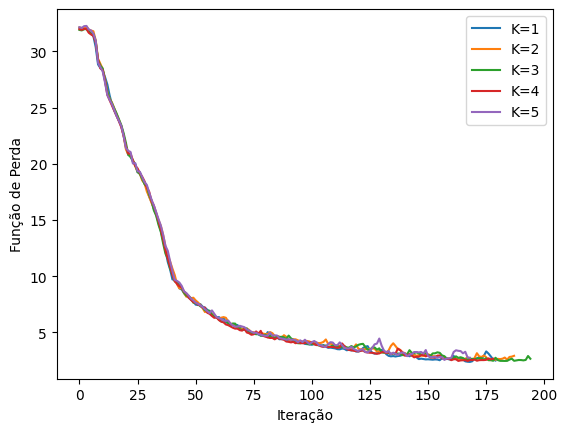

0.15753424657534246
   K  Score de Treinamento  Score de Teste  Ultima Perda
0  0              0.286938        0.311966      2.007858
1  1              0.239829        0.200855      2.221600
2  2              0.277302        0.230769      2.209291
3  3              0.226738        0.244635      2.268767
4  4              0.239572        0.227468      2.144778



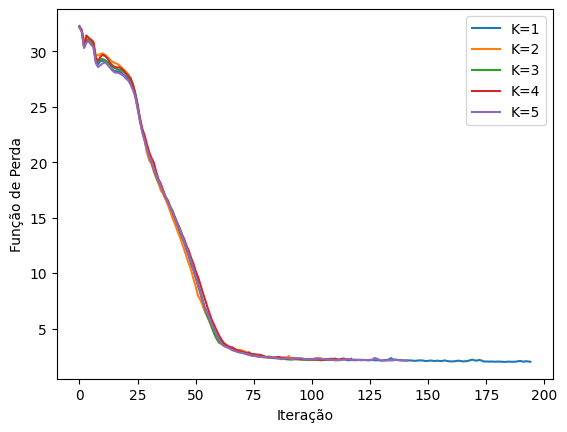

0.21575342465753425


In [ ]:
parameters = ['identity', 'constant', 5, (2, 2, 8)]
for df in dfs_quantity:
  x = df.iloc[:, df.columns != 'PriceRange']
  y = df['PriceRange']
  #Separação de 10% para teste (random_state = 100, para efeitos de reprodutibilidade)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=R_STATE)

  #One Hot Encoded
  df_combined = pd.concat([x_train, x_test])
  combined_encoded = pd.get_dummies(df_combined)
  x_train_encoded = combined_encoded[:len(x_train)]
  x_test_encoded = combined_encoded[len(x_train):]

  #Divisão de k = 5
  kf = StratifiedKFold(n_splits=parameters[2], shuffle = True, random_state=R_STATE)

  #Utilização do classificador multi perceptron
  clf = MLPClassifier(hidden_layer_sizes = parameters[3], max_iter=100000, activation='identity', solver='adam', learning_rate='constant', random_state=R_STATE)

  #Dados para os gráficos das funções de perda
  losses_data = []

  #Listas para exibir o dataframe
  scores_train = []
  scores_test = []
  losses = []
  df = pd.DataFrame()

  #Para cada fold, informar score de treinamento e teste
  for i, (train_i, test_i) in enumerate(kf.split(x_train, y_train)):

    clf.fit(x_train_encoded.iloc[train_i], y_train.iloc[train_i])

    #Score de Treinamento
    score_train = clf.score(x_train_encoded.iloc[train_i], y_train.iloc[train_i])
    scores_train.append(score_train)

    #Score de Teste
    score_test = clf.score(x_train_encoded.iloc[test_i], y_train.iloc[test_i])
    scores_test.append(score_test)

    #Guarda cada curva de perda
    losses_data.append(clf.loss_curve_)

    #Ultima perda registrada
    losses.append(clf.loss_)

  #Um dataframe criado para exibir os dados de uma forma mais organizada
  df_ = pd.DataFrame(data={"K": list(range(parameters[2])), "Score de Treinamento": scores_train, "Score de Teste": scores_test, "Ultima Perda": losses})
  print(df_)
  print()

  #Grafico da Curva de Perda
  for i, loss_curve in enumerate(losses_data):
    plt.plot(loss_curve, label=f"K={i+1}")
  plt.xlabel("Iteração")
  plt.ylabel("Função de Perda")
  plt.legend()
  plt.show()

  print(clf.score(x_test_encoded, y_test))

#### **Teste do <i>dfs_ranges</i>**

216


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


   K  Score de Treinamento  Score de Teste  Ultima Perda
0  0              0.344754        0.290598      4.268661
1  1              0.358672        0.307692      4.750740
2  2              0.462527        0.444444      1.588002
3  3              0.494118        0.493562      2.177074
4  4              0.285561        0.287554      3.300226



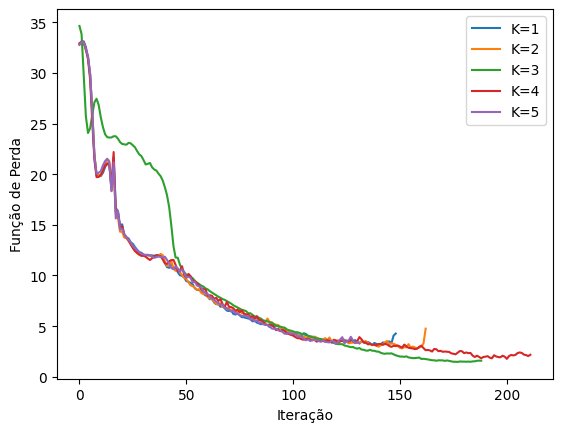

0.2534246575342466
270


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


   K  Score de Treinamento  Score de Teste  Ultima Perda
0  0              0.631692        0.632479      0.919690
1  1              0.702355        0.683761      0.783556
2  2              0.604925        0.598291      1.526770
3  3              0.607487        0.562232      0.934082
4  4              0.691979        0.669528      0.857747



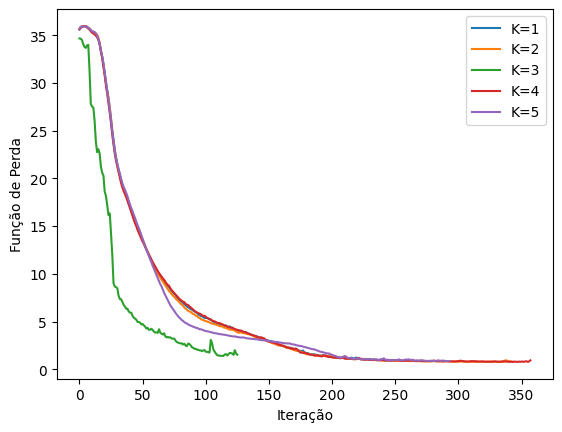

0.6917808219178082


In [ ]:
for df in dfs_range:
  x = df.iloc[:, df.columns != 'PriceRange']
  y = df['PriceRange']
  parameters = ['identity', 'constant', 5, (2, 2, 8)]

  #Separação de 10% para teste (random_state = 100, para efeitos de reprodutibilidade)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=R_STATE)

  #One Hot Encoded
  df_combined = pd.concat([x_train, x_test])
  combined_encoded = pd.get_dummies(df_combined)
  x_train_encoded = combined_encoded[:len(x_train)]
  x_test_encoded = combined_encoded[len(x_train):]
  print(len(x_train_encoded.columns))

  #Divisão de k = 5
  kf = StratifiedKFold(n_splits=parameters[2], shuffle = True, random_state=R_STATE)

  #Utilização do classificador multi perceptron
  clf = MLPClassifier(hidden_layer_sizes = parameters[3], max_iter=100000, activation='identity', solver='adam', learning_rate='constant', random_state=R_STATE)

  #Dados para os gráficos das funções de perda
  losses_data = []

  #Listas para exibir o dataframe
  scores_train = []
  scores_test = []
  losses = []
  df = pd.DataFrame()

  #Para cada fold, informar score de treinamento e teste
  for i, (train_i, test_i) in enumerate(kf.split(x_train, y_train)):

    clf.fit(x_train_encoded.iloc[train_i], y_train.iloc[train_i])

    #Score de Treinamento
    score_train = clf.score(x_train_encoded.iloc[train_i], y_train.iloc[train_i])
    scores_train.append(score_train)

    #Score de Teste
    score_test = clf.score(x_train_encoded.iloc[test_i], y_train.iloc[test_i])
    scores_test.append(score_test)

    #Guarda cada curva de perda
    losses_data.append(clf.loss_curve_)

    #Ultima perda registrada
    losses.append(clf.loss_)

  #Um dataframe criado para exibir os dados de uma forma mais organizada
  df_ = pd.DataFrame(data={"K": list(range(parameters[2])), "Score de Treinamento": scores_train, "Score de Teste": scores_test, "Ultima Perda": losses})
  #df_result = pd.DataFrame(data={"K": best_parameters[3], "Score de Teste": best_score, "\"Melhor\" Perda": best_losses})
  print(df_)
  print()

  #Grafico da Curva de Perda
  for i, loss_curve in enumerate(losses_data):
    plt.plot(loss_curve, label=f"K={i+1}")
  plt.xlabel("Iteração")
  plt.ylabel("Função de Perda")
  plt.legend()
  plt.show()

  print(clf.score(x_test_encoded, y_test))

In [ ]:
#Pegando valor previsto
y_test_pred = clf.predict(x_test_encoded)

#Construindo matrix de confusão
cm = confusion_matrix(y_test, y_test_pred)

#Converte para dataframe
cm_df = pd.DataFrame(cm, index=clf.classes_, columns=clf.classes_)

#Cria o gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()